In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import sys
import time
import requests
import pickle
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

In [2]:
token = ...
api_v = ...
user_id = '141466889'

In [3]:
res_users = requests.get(f'https://api.vk.com/method/users.get?user_ids=141466889&fields=bdate, city&access_token={token}&v={api_v}')

In [4]:
def request_url(method_name, parameters, access_token=True):
    
    req_url = 'https://api.vk.com/method/{method_name}?{parameters}&v={api_v}'.format(
        method_name=method_name, api_v=api_v, parameters=parameters)

    if access_token:
        req_url = '{}&access_token={token}'.format(req_url, token=token)

    return req_url

In [5]:
def base_info(ids):
    r = requests.get(request_url('users.get', 'user_ids=%s&fields=photo' % (','.join(map(str, ids))), access_token=True)).json()
    r = r['response'][0]
    # Проверяем, если id из settings.py не деактивирован
    return r['first_name'], r['last_name'], r['photo']

In [6]:
def friends(id):
    r = requests.get(request_url('friends.get',
            'user_id=%s&fields=uid,first_name,last_name,photo,country,city,sex,bdate,education' % id, access_token=True)).json()['response']
    r = list(filter((lambda x: 'deactivated' not in x.keys()), r['items']))
    return {item['id']: item for item in r}

In [8]:
# для поиска удаленых друзей
def friends_d(id):
    r = requests.get(request_url('friends.get',
            'user_id=%s&fields=uid,first_name,last_name,photo,country,city,sex,bdate,education' % id, access_token=True)).json()['response']
    r = list(filter((lambda x: 'deactivated' in x.keys()), r['items']))
    return {item['id']: item for item in r}

In [9]:
all_friends_d = friends_d(user_id)

In [10]:
my_name, my_last_name, photo = base_info([user_id])
all_friends = friends(user_id)

In [11]:
parts = lambda lst, n=25: (lst[i:i + n] for i in iter(range(0, len(lst), n)))
make_targets = lambda lst: ",".join(str(id) for id in lst)

In [12]:
result = []
for i in parts(list(all_friends.keys())):
    r = requests.get(request_url('friends.getMutual',
                    'source_uid=%s&target_uids=%s' % (user_id, make_targets(i)), access_token=True)).json()['response']
    time.sleep(1)
    result.append(r)

In [13]:
all_friends_df=pd.DataFrame([all_friends[i] for i in list(all_friends.keys())])

In [14]:
all_friends_df=all_friends_df[['id','first_name','last_name','photo','university_name','city','sex']]

In [31]:
node=list(all_friends.keys())
G=nx.Graph()
G.add_nodes_from(node)
for k in result:
    for i in k:
        a=[(i['id'],j) for j in i['common_friends']]
        G.add_edges_from(a)
G.remove_node(221924329)
#G.remove_node(269748463)
#G.remove_node(521958424)
attr_first_name = {}
attr_last_name = {}
attr_photo = {}
attr_university_name = {}
attr_city = {}
attr_sex = {}

for id, first_name,last_name,photo,university_name,city,sex in all_friends_df[['id','first_name','last_name','photo','university_name','city','sex']].values:
    attr_first_name[id] = first_name
    attr_last_name[id] = last_name
    attr_photo[id]=photo
    attr_university_name[id]=university_name
    attr_city[id]=city
    attr_sex[id]=sex
nx.set_node_attributes(G, attr_first_name, 'first_name')
nx.set_node_attributes(G, attr_last_name, 'last_name')
nx.set_node_attributes(G, attr_photo, 'photo')
nx.set_node_attributes(G, attr_university_name, 'university_name')
nx.set_node_attributes(G, attr_city, 'city')
nx.set_node_attributes(G, attr_sex, 'sex')

In [32]:
dict_university_color={}
for node in list(G.nodes()):
    if G.nodes[node]['university_name']=='МГТУ им. Н. Э. Баумана':
        dict_university_color[node]='tab:blue'
    else:
        dict_university_color[node]='gray'
        
dict_sex_color={}
for node in list(G.nodes()):
    if G.nodes[node]['sex']==1:
        dict_sex_color[node]='tab:blue'
    else:
        dict_sex_color[node]='tab:green'

In [33]:
nx.set_node_attributes(G, dict_university_color, 'color_university')
nx.set_node_attributes(G, dict_sex_color, 'color_sex')

In [34]:
def select_gygantic_component(g: nx.Graph) -> nx.Graph:
    M=max(nx.connected_components(g), key=len)
    max_graph=g.subgraph(M).copy()
    return max_graph

In [35]:
g=select_gygantic_component(G)

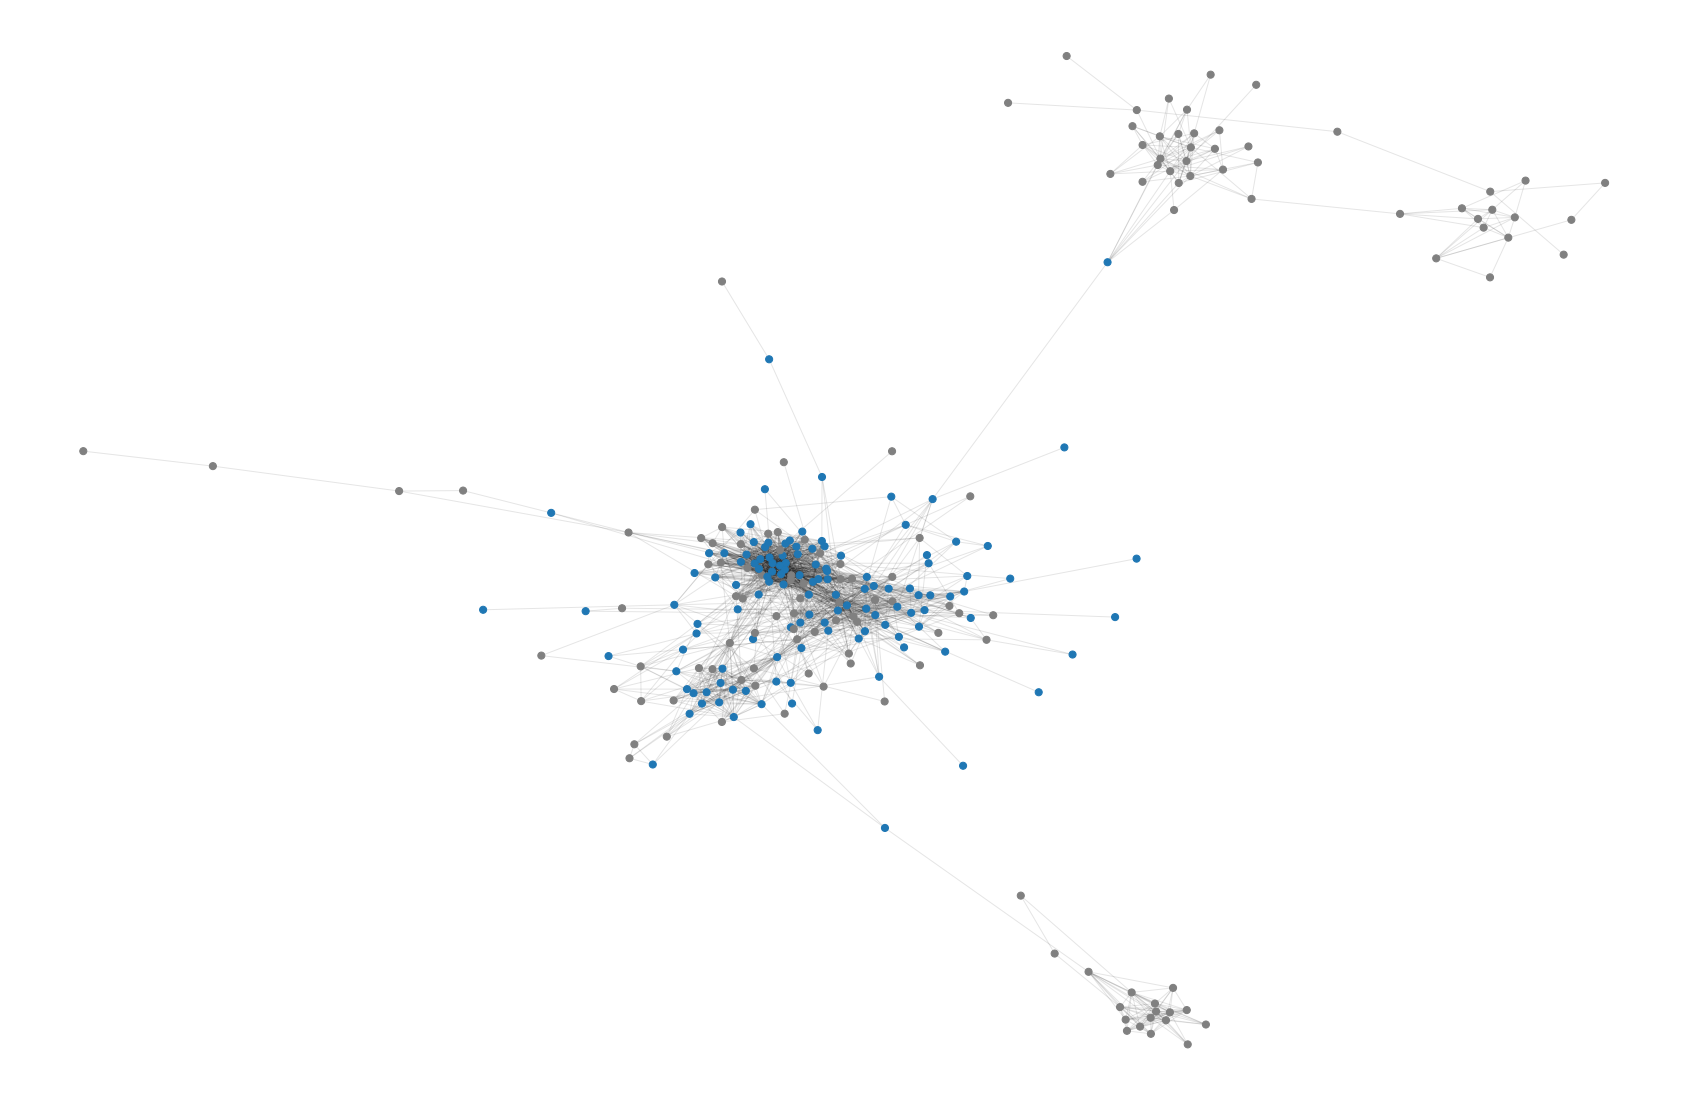

In [107]:
plt.figure(figsize=(10*3, 20))
pos=nx.spring_layout(g,k=0.1)
nx.draw_networkx_nodes(g, pos,node_size=50,node_color=list(nx.get_node_attributes(g, 'color_university').values()))
nx.draw_networkx_edges(g, pos, alpha=0.1)
plt.axis('off')
plt.show()

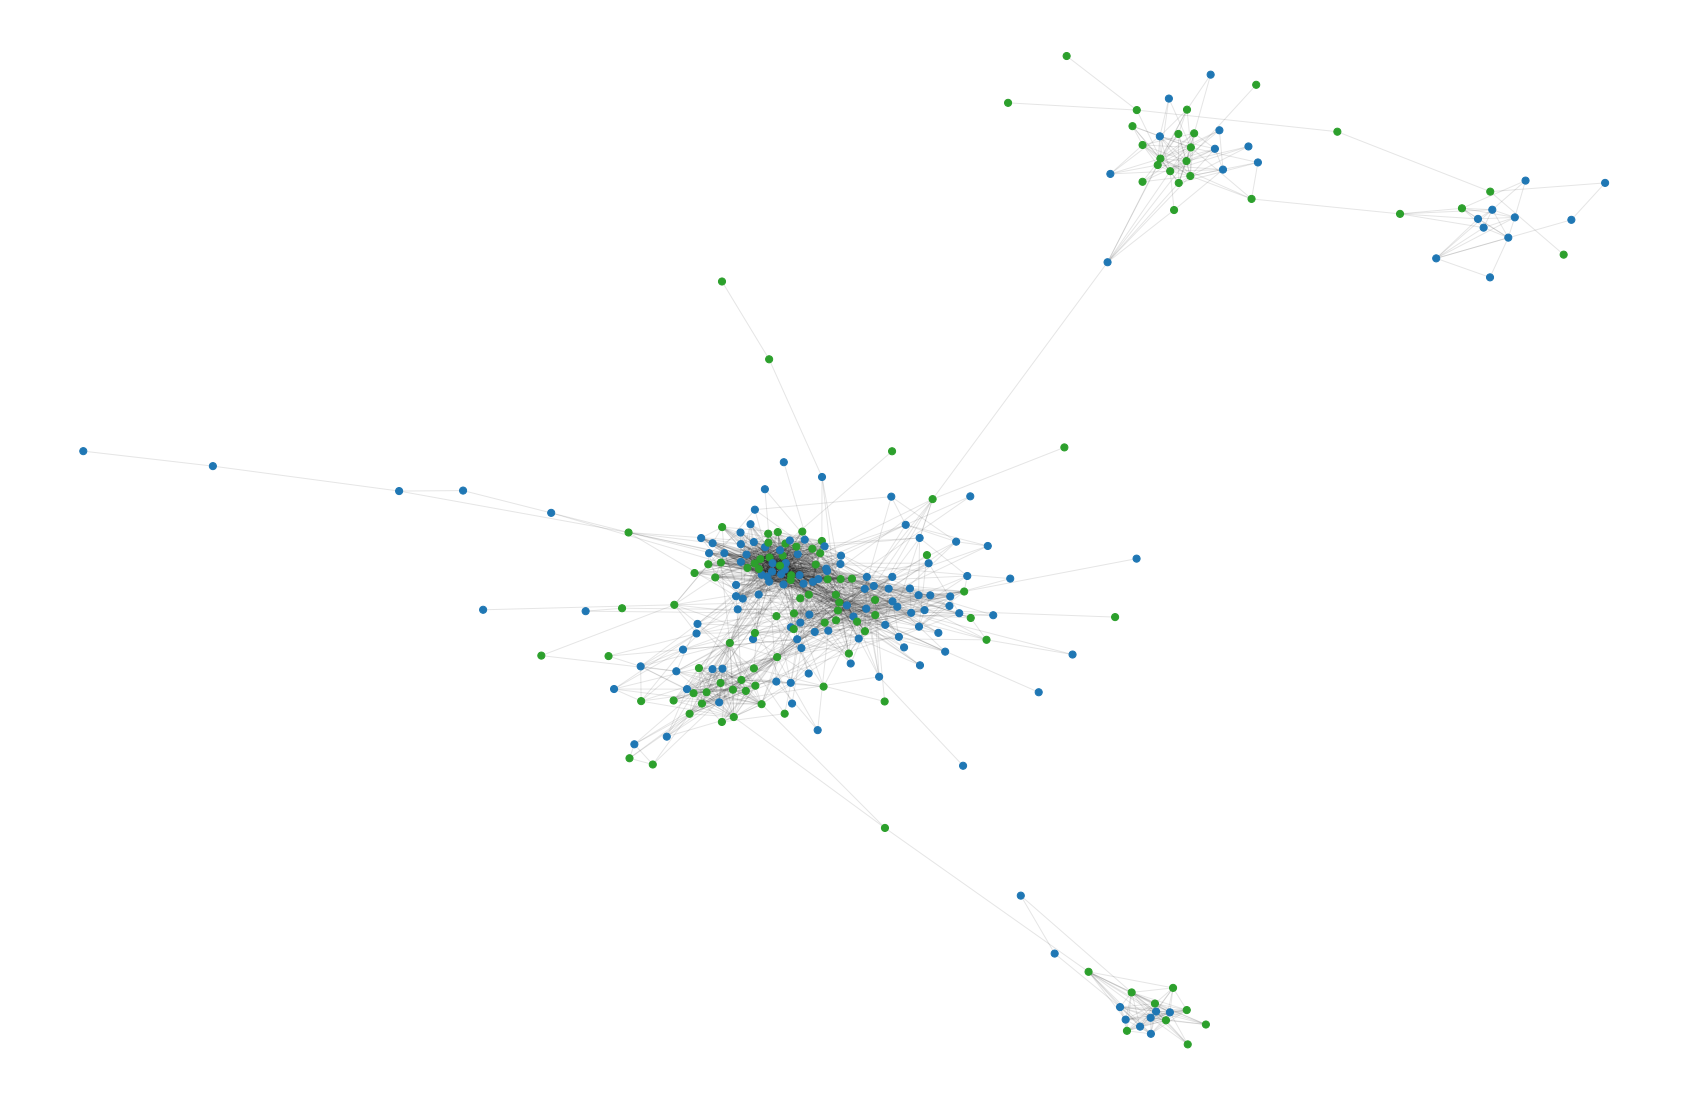

In [108]:
plt.figure(figsize=(10*3, 20))
nx.draw_networkx_nodes(g, pos,node_size=50,node_color=list(nx.get_node_attributes(g, 'color_sex').values()))
nx.draw_networkx_edges(g, pos, alpha=0.1)
plt.axis('off')
plt.show()

Описание графа

In [45]:
n_nodes=len(g) # кол-во вершин
n_edges=g.number_of_edges() # кол-во ребер
print(n_nodes)
print(n_edges)

260
2047


In [48]:
diameter = nx.algorithms.distance_measures.diameter(g)
radius = nx.algorithms.distance_measures.radius(g)
print(diameter)
print(radius)

14
7


In [50]:
av_clustering=nx.average_clustering(g)
print(av_clustering)

0.5057344366255323


4.028185328185328


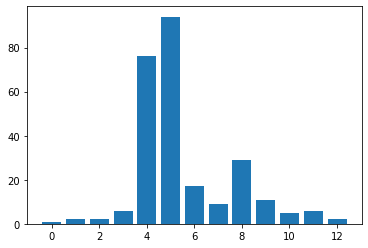

In [61]:
path_l=list([j for i,j in nx.shortest_path_length(g)][0].values())
bins, freq = np.unique(path_l, return_counts=True)
plt.bar(bins, freq)
print(nx.average_shortest_path_length(g))

In [67]:
degree_dist=list(dict(g.degree).values())

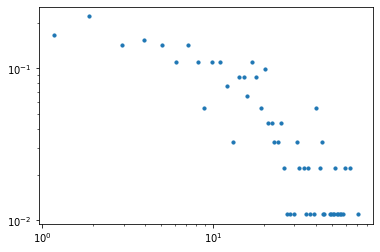

In [72]:
hist, bin_edges = np.histogram(degree_dist, bins=200, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=10)
plt.xscale('log')
plt.yscale('log')

Центральности

In [73]:
from typing import Dict, List
def centralities(G: nx.Graph) -> Dict[str, np.array]:
    """
    Calculate degree, closeness, betweenness centralities of the graph
    
    :param G: Moscow undeground graph
    :return: mapping of centrality names (degree, closeness, betweenness) to np.array of its values
    """
    dict_centralities=dict()
    dict_centralities['degree']=np.array(list(nx.degree_centrality(G).values()))
    dict_centralities['closeness']=np.array(list(nx.closeness_centrality(G).values()))
    dict_centralities['betweenness']=np.array(list(nx.betweenness_centrality(G).values()))
    return dict_centralities

In [74]:
c = centralities(g)

In [83]:
def top10_centralities(G: nx.Graph) -> Dict[str, pd.DataFrame]:
    """
    Create table of top 10 nodes by degree, closeness, betweenness centralities
    """
    centrality = nx.degree_centrality(G)
    top = np.array(sorted(centrality.items(), key=lambda i: i[1], reverse=True)[:10])[:, 0].astype(int)
    first_name = []
    last_name = []
    university = []
    c =[] 
    for i in top:
        first_name.append(G.nodes[i]['first_name'])
        last_name.append(G.nodes[i]['last_name'])
        university.append(G.nodes[i]['university_name'])
        c.append(centrality[i])
    df1 = pd.DataFrame({'first_name': first_name, 'last_name' : last_name,'university_name':university, 'centrality': c}).fillna("нет")
    centrality = nx.closeness_centrality(G)
    top = np.array(sorted(centrality.items(), key=lambda i: i[1], reverse=True)[:10])[:, 0].astype(int)
    first_name = []
    last_name = []
    university = []
    c =[] 
    for i in top:
        first_name.append(G.nodes[i]['first_name'])
        last_name.append(G.nodes[i]['last_name'])
        university.append(G.nodes[i]['university_name'])
        c.append(centrality[i])
    df2 = pd.DataFrame({'first_name': first_name, 'last_name' : last_name,'university_name':university, 'centrality': c}).fillna("нет")
    centrality = nx.betweenness_centrality(G)
    top = np.array(sorted(centrality.items(), key=lambda i: i[1], reverse=True)[:10])[:, 0].astype(int)
    first_name = []
    last_name = []
    university = []
    c =[] 
    for i in top:
        first_name.append(G.nodes[i]['first_name'])
        last_name.append(G.nodes[i]['last_name'])
        university.append(G.nodes[i]['university_name'])
        c.append(centrality[i])
    df3 = pd.DataFrame({'first_name': first_name, 'last_name' : last_name,'university_name':university, 'centrality': c}).fillna("нет")
    return {'degree': df1, 'closeness': df2, 'betweenness': df3}

In [84]:
top_dfs = top10_centralities(g)

Degree centrality


,first_name,last_name,university_name,centrality
0,Елизавета,Гражданинова,МГТУ им. Н. Э. Баумана,0.274131
1,Максим,Ковалев,,0.243243
2,Veronika,Gamalia,МГТУ им. Н. Э. Баумана,0.243243
3,Мартин,Разроев,нет,0.227799
4,Влад,Тищук,МГТУ им. Н. Э. Баумана,0.227799
5,Алексей,Молчанов,,0.223938
6,Василий,Платонов,МГТУ им. Н. Э. Баумана,0.216216
7,Дарья,Терёшкина,нет,0.212355
8,Ханна,Гринберг,МГТУ им. Н. Э. Баумана,0.208494
9,Бекзат,Бекбусинова,МГТУ им. Н. Э. Баумана,0.204633


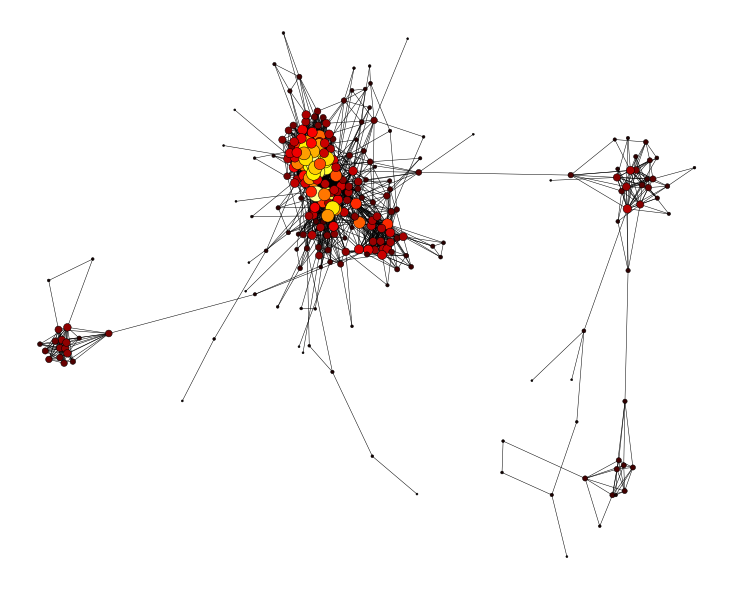

Closeness centrality


,first_name,last_name,university_name,centrality
0,Ангелина,Коновалова,МГТУ им. Н. Э. Баумана,0.375907
1,Елизавета,Гражданинова,МГТУ им. Н. Э. Баумана,0.370000
2,Мартин,Разроев,нет,0.365303
3,Максим,Ковалев,,0.362745
4,Виктория,Кораблева,МГТУ им. Н. Э. Баумана,0.362745
5,Алексей,Молчанов,,0.361227
6,Анастасия,Червинская,МГТУ им. Н. Э. Баумана,0.358230
7,Дарья,Терёшкина,нет,0.357241
8,Павел,Кислов,,0.356259
9,Бекзат,Бекбусинова,МГТУ им. Н. Э. Баумана,0.355769


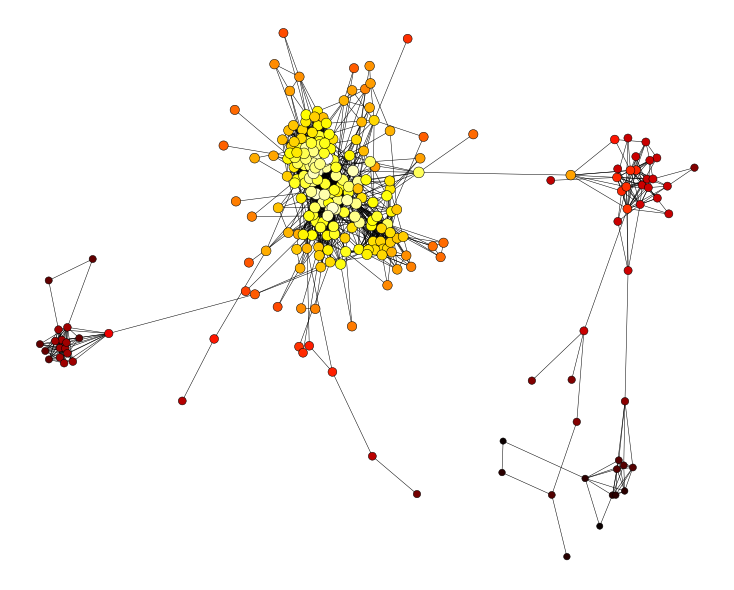

Betweenness centrality


,first_name,last_name,university_name,centrality
0,Александр,Пантыкин,МГТУ им. Н. Э. Баумана,0.290205
1,Елизавета,Микотина,МГТУ им. Н. Э. Баумана,0.278366
2,Юра,Щерба,МГТУ им. Н. Э. Баумана,0.129837
3,Ангелина,Коновалова,МГТУ им. Н. Э. Баумана,0.125073
4,Михаил,Саматов,МИЭМ,0.123160
5,Клим,Корнеевец,СГМУ им. В. И. Разумовского,0.122268
6,Никита,Рышков,МГТУ им. Н. Э. Баумана,0.081058
7,Юрий,Антонов,ОВЗРКУ,0.079417
8,Севернов,Валерий,,0.072326
9,Игорь,Бойко,,0.059763


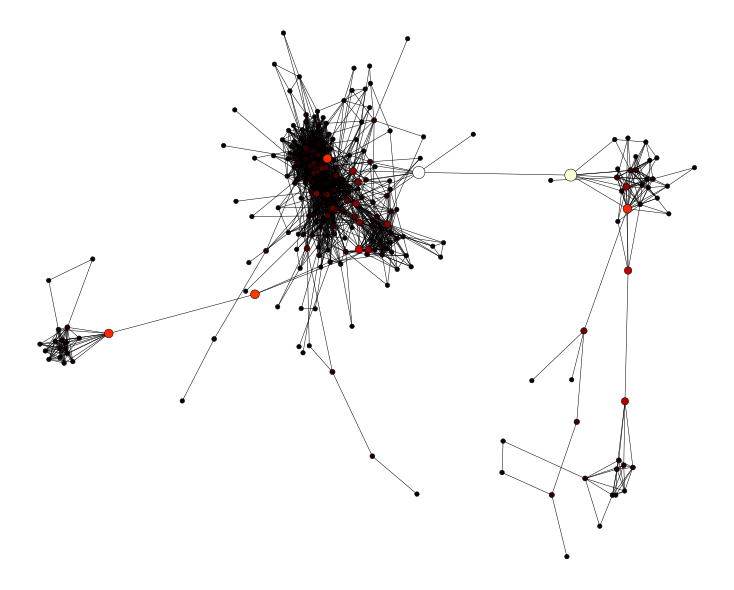

In [85]:
cases = [['degree', 1000, 0, 'Degree centrality'], 
         ['closeness', 350, 0, 'Closeness centrality'], 
         ['betweenness', 450, 20, 'Betweenness centrality']]
for c_key, scale, bias, title in cases:
    print(title)
    display(top_dfs[c_key])
    plt.figure(figsize=(10, 8))
    nx.draw(g, 
            pos,
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            cmap=plt.cm.hot,
            node_size=c[c_key]*scale + bias,
            node_color=c[c_key])
    plt.show()

PageRank calculation

In [86]:
def page_rank(G, alpha, k):
    A = nx.to_numpy_array(G)
    P = transition_matrix(A)
    v = teleportation_vector(A)
    rank = np.ones(A.shape[0]) / A.shape[0]
    for _ in range(k):
        rank = update_rank(rank, P, v, alpha)
    return np.array(rank)

In [87]:
def transition_matrix(A):
    A= (A.T/(A.sum(axis=1))).T
    return A

In [88]:
def teleportation_vector(A):
    return np.ones(A.shape[0])/A.shape[0]

In [89]:
def update_rank(rank, P, v, alpha):
    return alpha * np.dot(P.T, rank) + (1 - alpha) * v

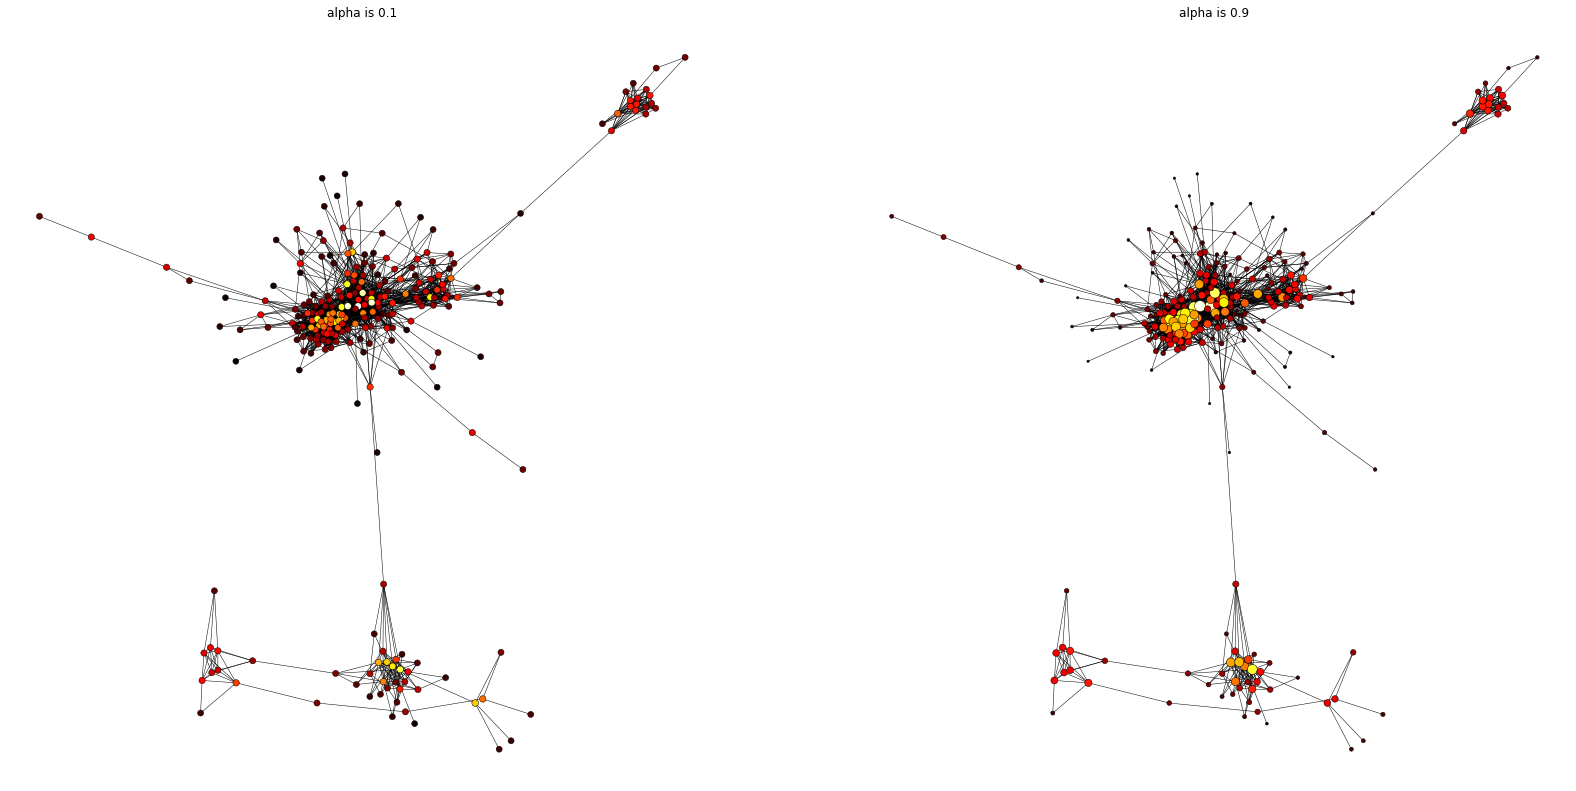

In [95]:
plt.figure(figsize=(14*2, 7*2))

cases = [0.1, 0.9]

for i, alpha in enumerate(cases):
    plt.subplot(1, 2, i+1)
    PR = page_rank(g, alpha, 10)
    nx.draw(g, 
            pos,
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            cmap=plt.cm.hot,
            node_size=PR*10e3,
            node_color=PR)
    plt.title('alpha is {}'.format(alpha))

Community Detection

In [109]:
def k_core_decompose(G):
    return np.fromiter(nx.core_number(G).values(), int)

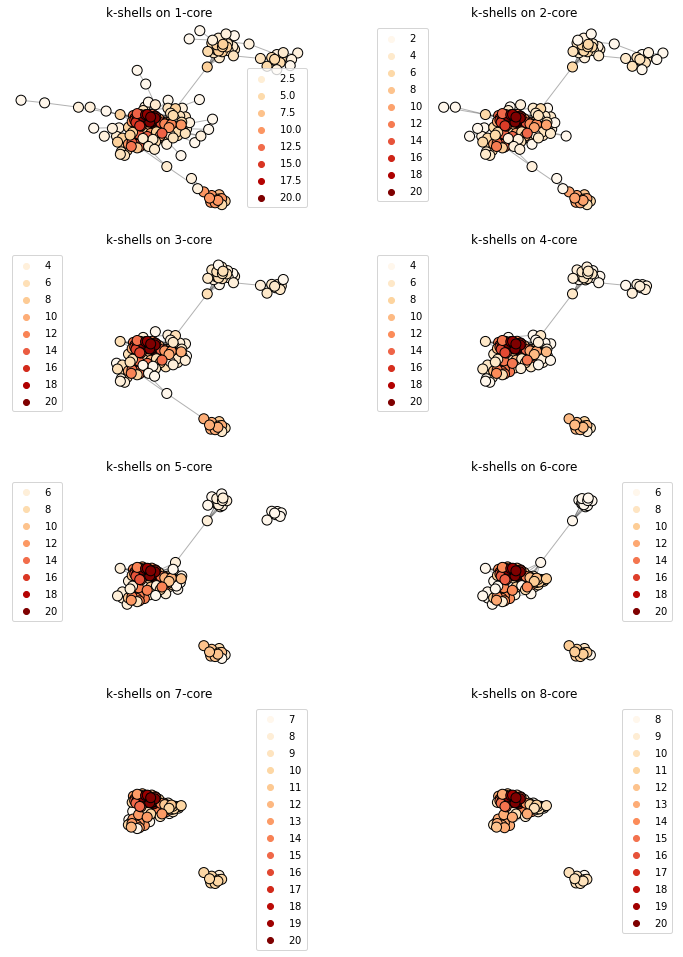

In [112]:
plt.figure(figsize=(8*1.5, 8*2))

x_max, y_max = np.array(list(pos.values())).max(axis=0)
x_min, y_min = np.array(list(pos.values())).min(axis=0)

for i in range(8):
    plt.subplot(4, 2, i+1)
    subG = nx.k_core(g, i+1)
    nodes = nx.draw_networkx_nodes(
        subG, 
        pos,
        cmap=plt.cm.OrRd,
        node_color=k_core_decompose(subG), 
        node_size=100, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(
        subG, 
        pos,
        alpha=0.3,
        width=1, 
        edge_color='black'
    )
    eps = (x_max - x_min) * 0.05
    plt.xlim(x_min-eps, x_max+eps)
    plt.ylim(y_min-eps, y_max+eps)
    plt.legend(*nodes.legend_elements())
    plt.axis('off')
    plt.title('k-shells on {}-core'.format(i+1))

In [113]:
import math
def norm_laplacian(A):
    G=nx.from_numpy_array(A)
    deg_dist=np.array(list(dict(G.degree).values()))
    D_s=np.diag(deg_dist**(-1/2))
    D=np.diag(deg_dist)
    L=np.dot(np.dot(D_s,(D-A)),D_s)
    return L,deg_dist

In [114]:
A = nx.to_numpy_array(g)
L, degree_seq = norm_laplacian(A)

In [115]:
def spectral_embedding(L, degree_seq, n_components):
    w,vecs=np.linalg.eigh(L)
    vecs=np.array(vecs)
    for i,d in enumerate(degree_seq):
        vecs[i,:]=vecs[i,:]*(1/math.sqrt(d))
    return vecs[:,1:n_components+1]

In [116]:
embedding = spectral_embedding(L, degree_seq, 3)

In [117]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from zlib import adler32
from sklearn.neighbors import kneighbors_graph

In [118]:
def spectral_clustering(G, n_clusters, n_components):
    A = nx.to_numpy_array(G)
    L, degree_seq = norm_laplacian(A)
    embedding = spectral_embedding(L, degree_seq, n_components)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    return kmeans.labels_

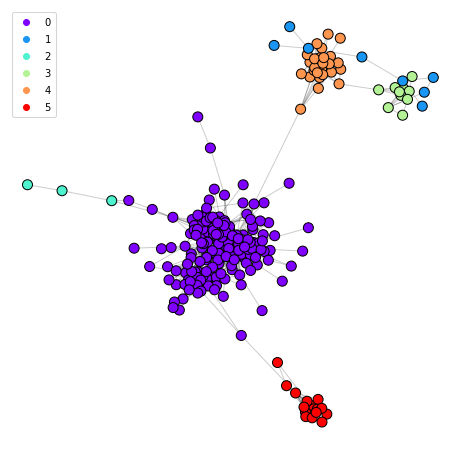

In [119]:
plt.figure(figsize=(8, 8))
nodes = nx.draw_networkx_nodes(
    g, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=spectral_clustering(g, 6, 5), 
    node_size=100, 
    linewidths=1, 
    edgecolors='black'
)
nx.draw_networkx_edges(
    g,
    pos,
    alpha=0.2,
    edge_color='black'
)
plt.axis('off')
plt.legend(*nodes.legend_elements())
plt.show()